In [ ]:
%pip install pymc3 arviz mkl mkl-service

In [2]:
import pymc3 as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
ds = xr.open_dataset("./temperature_interp.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 745, depth: 63)
Coordinates:
  * depth             (depth) float64 -194.0 -191.0 -187.9 ... -11.1 -8.048 -5.0
  * time              (time) float64 0.0 60.0 120.0 ... 4.458e+04 4.464e+04
Data variables:
    temp_prof         (time, depth) float64 ...
    temp_prof_filled  (time, depth) float64 ...
    temp_roms         (time, depth) float64 ...
    ocean_time        (time) datetime64[ns] ...

In [4]:
# 1.Data Preparation

# flatten data arrays
observed_flat = ds.temp_prof_filled.values.ravel() # exclude NaNs
model_flat = ds.temp_roms.values.ravel()

print('Data length is {}'.format(len(observed_flat)))
print('Observation Mean:{}, Model Mean:{}'.format(observed_flat.mean(), model_flat.mean()))

Data length is 46935
Observation Mean:8.63410486514633, Model Mean:9.207037195486867


**Bayesian approaches** provide a probalilistic interpretation of the regression results \
(i.e., obtaining a distribution over predictions), the key benefit is the **quantification of uncertainty**.

**A Bayesian Model (linear):** \
observed=$\alpha$+$\beta\times$model+$\epsilon$ \
Where: \
$\alpha$ is the intercept. \
$\beta$ is the regression coefficient. \
$\epsilon$ is the error term, which we'll assume follows a normal distribution.

In [5]:
# 2.Define the Bayesian Model

with pm.Model() as model:
    # Priors for unknown model parameters (`mu`:mean, 'sigma':standard deviation)
    alpha = pm.Normal('alpha', mu=9, sigma=10) # intercept
    beta = pm.Normal('beta', mu=9, sigma=10) # slope
    sigma = pm.HalfNormal('sigma', sigma=10) # standard deviation

    # Expected outcome (linear relationship)
    mu = alpha + beta * model_flat
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=observed_flat)


## Computing the Posterior:
Using Bayes' theorem, combine the likelihood and the prior to get the posterior distribution. In practice, this often requires numerical methods like Markov Chain Monte Carlo (MCMC) because the posterior can't be computed analytically.

**MCMC** is a class of algorithms used in Bayesian statistics to estimate the posterior distribution of a model's parameters.
* **The Core Idea**: For many complex models, it's challenging (or impossible) to directly compute the posterior distribution. Instead, MCMC algorithms generate samples from the posterior distribution, which can then be used to approximate this distribution and make inferences about the model parameters.
* **Markov Chains**:  The "Markov Chain" in MCMC refers to the fact that each sample depends only on the previous sample (or samples), not on any earlier samples, which is the property of a Markov process.

### Why use MCMC?
1. **Flexibility**: MCMC can handle complex models where traditional methods fail.
2. **Full Uncertainty Quantification**: Instead of just getting point estimates, you get a full posterior distribution for each parameter.
3. **Integration Over Uncertainty**: Rather than fixing parameters at specific values, MCMC integrates over all possibilities, giving a richer understanding of potential outcomes.

In [6]:
# 3.Conduct MCMC Sampling

with model:
    # Use the No-U-Turn Sampler (NUTS) which is efficient for high dimensional models
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# This will run the MCMC sampling, drawing 2000 samples (after an initial "tuning" phase of 1000 samples)
# Given the size of the datasets, it's good to use a larger 'tune' value to ensure the sampler finds a good starting point
# The 'target_accept' is set to ensure a high acceptance rate that helps achieve better convergence for complex models.
summary = az.summary(trace)
print(summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 117 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  3.370  0.017   3.338    3.403        0.0      0.0    1338.0    1496.0   
beta   0.572  0.002   0.568    0.575        0.0      0.0    1316.0    1369.0   
sigma  0.998  0.003   0.992    1.004        0.0      0.0    1812.0    1923.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


## Interpretation:
* The estimated intercept (`alpha`) is 3.37, and the slope (`beta`) is 0.57. This means that for each unit increase in the model data, the observed data is expected to increase by approximately 0.57 units, on average.
* The residuals of this model (the differences between the observed values and the values predicted by the model) have an estimated standard deviation (`sigma`) of 0.998.
* The provided `HDIs` (the 3rd and 97th percentiles of the highest posterior density interval) give a range for each parameter in which the true value is likely to lie with 94% confidence.
* The `ESS` (effective sample size) values suggest that the sampling was efficient and there's a good number of effective samples for the posterior estimates.

In [7]:
print(model)
print(trace)

      alpha ~ Normal
       beta ~ Normal
sigma_log__ ~ TransformedDistribution
      sigma ~ HalfNormal
        obs ~ Normal
Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


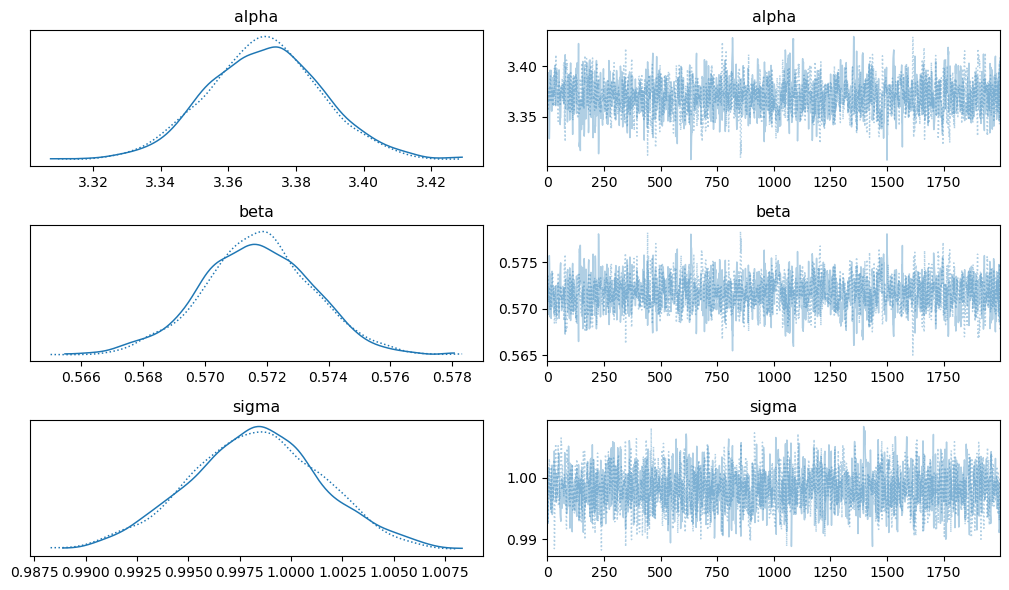

In [13]:
# 4.Visualize Results

# Plot the posterior distributions
# Adjusting for potential overlap

plt.rcParams['font.size'] = 10
fig = az.plot_trace(trace, figsize=(10,6))
#az.plot_trace(trace, var_names=("alpha", "beta"))
plt.tight_layout()

plt.savefig('./Figs/BayesianRegression.png', dpi=300, bbox_inches='tight')